# Лабораторная работа №2 (Проведение исследований с логистической и линейной регрессией)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

# 1. Выбор начальных условий

### a. Выбрать набор данных для задачи классификации - Задача по оценке Качества вина
1 - fixed acidity - фиксированная кислотность\
2 - volatile acidity - летучая кислотность\
3 - citric acid - лимонная кислота\
4 - residual sugar - остаточный сахар\
5 - chlorides - хлориды\
6 - free sulfur dioxide - свободный диоксид серы\
7 - total sulfur dioxide - общий диоксид серы\
8 - density - плотность\
9 - pH\
10 - sulphates - сульфаты\
11 - alcohol - спирт\
Выходная переменная (на основе сенсорных данных):\
12 - quality - качество (оценка от 0 до 10)

### b.Выбрать набор данных для задачи регрессии - Задача по предсказанию баллов за экзамен у студентов
1 - student_id - ID студента\
2 - age - возраст\
3 - gender - пол\
4 - major - специальность\
5 - study_hours_per_day - учебные часы в день\
6 - social_media_hours - часы в соцсетях\
7 - netflix_hours - часы просмотра Netflix\
8 - part_time_job - подработка\
9 - attendance_percentage - процент посещаемости\
10 - sleep_hours - часы сна\
11 - diet_quality - качество питания\
12 - exercise_frequency - частота занятий спортом\
13 - parental_education_level - уровень образования родителей\
14 - internet_quality - качество интернета\
15 - mental_health_rating - оценка психического здоровья\
16 - extracurricular_participation - участие во внеурочной деятельности\
17 - previous_gpa - предыдущий средний балл\
18 - semester - семестр\
19 - stress_level - уровень стресса\
20 - dropout_risk - риск отчисления\
21 - social_activity - социальная активность\
22 - screen_time - время у экрана\
23 - study_environment - учебная среда\
24 - access_to_tutoring - доступ к репетиторству\
25 - family_income_range - диапазон дохода семьи\
26 - parental_support_level - уровень поддержки родителей\
27 - motivation_level - уровень мотивации\
28 - exam_anxiety_score - балл тревожности на экзаменах\
29 - learning_style - стиль обучения\
30 - time_management_score - балл управления временем\
Выходная переменная:\
31 - exam_score - оценка за экзамен\

In [16]:
Wine_data = pd.read_csv('data/classification/WineQT.csv').set_index('Id')
Student_data = pd.read_csv('data/Regression/enhanced_student.csv').set_index('student_id')

### c. Выбрать метрики качества и обосновать их выбор

#### Метрики выбранные для Датасета про Качество вина (Классификация):
1.Accuracy - Самая базовая метрика, доля правильно предсказанных. Если классы сбалансированы\
2.Precision-weighted - если важно не завышать оценки\
3.recall-weighted - если важно не занижать оценки\
4.F1-score (weighted) - Метрика для случая если целевая переменная имеет сильный дисбаланс классов, баланс precision/recall

#### Метрики выбранные для Датасета про студентов (Регрессии):
1.MAE (Mean Absolute Error) - интерпретируем в исходных единицах\
2.RMSE (Root Mean Square Error) - штрафует за большие ошибки\
3.MAPE (Mean Absolute Percentage Error) - относительная ошибка в %

# 2.Создание бейзлайна и оценка качества

Перед началом создания и обучения моделей закодируем данные в Датасете студентов для корректной работы моделей sklearn

In [23]:
categorical_cols = Student_data.select_dtypes(include=['object']).columns # Берём все категориальные данные

binary_cols = [col for col in categorical_cols if Student_data[col].nunique() == 2] # Разделяем на бинарные и небинарные
non_binary_cols = [col for col in categorical_cols if Student_data[col].nunique() > 2]
Student_data = pd.get_dummies(Student_data, columns=binary_cols, drop_first=True) # get_dummies для бинарных

if non_binary_cols:
    encoder = OrdinalEncoder() # OrdinalEncoder для небинарных
    Student_data[non_binary_cols] = encoder.fit_transform(Student_data[non_binary_cols])

Кодировка данных происходит благодаря get_dummies и OrdinalEncoder, первые используем для кодировки бинарных признаков, второй это базовый энкодер который используется для небинарных признаков

### a.Обучить модели из sklearn (для классификации и регрессии) для выбранных наборов данных

Разделим данные на X - признаки и Y - Целевая

In [28]:
X_Wine = Wine_data.drop(['quality'], axis = 1)
y_Wine = Wine_data['quality']

X_Student = Student_data.drop(['exam_score'], axis = 1)
y_Student = Student_data['exam_score']

разделим данные на обучающую и тестовую выборку при помощи train_test_split

In [31]:
X_train_Student, X_test_Student, y_train_Student, y_test_Student = train_test_split(X_Student, y_Student, test_size=0.33, random_state=42)
X_train_Wine, X_test_Wine, y_train_Wine, y_test_Wine = train_test_split(X_Wine, y_Wine, test_size=0.33, random_state=42)

Создадим и обучим модель на разделённых данных

In [155]:
Logisctic_wine = LogisticRegression(multi_class='multinomial', solver='lbfgs')
Linear_Student = LinearRegression()

Logisctic_wine.fit(X_train_Wine, y_train_Wine)
Linear_Student.fit(X_train_Student, y_train_Student)

LinearRegression()

После обучения обоих моделей выведем все метрики на экран и сделаем выводы по работе моделей

In [157]:
Wine_predict = Logisctic_wine.predict(X_test_Wine)
Student_predict = Linear_Student.predict(X_test_Student)

print('Метрики Классификации качества Вина:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted", zero_division=True)} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина:
Accuracy:  0.5793650793650794 
Recall:    0.5793650793650794 
Precision: 0.551698807504051 
F1:        0.5326750350188905
Метрики Регрессии по экзаменам студентов:
MAE:  3.2078495662195614 
RMSE: 4.198402708194104 
MAPE: 0.038189728059923704


### Метрики Классификации качества Вина
Метрики на достаточно сырых данных Логистическая регрессия показала себя неплохо, но видна разница Accuracy = 0.57 и F1 = 0.53, что говорит о вмешательстве дисбаланса классов, который стоит устранить

### Метрики Регрессии по экзаменам студентов
Метрики Регрессии на датасете студентов показали себя превосходно, они оказались лучше чем метрики KNN на новом бейзлайне с прошлой работы. Процентная абсолютная ошибка оставила лишь 3.8%. Но это может быть переобучением.

# 3.Улучшение бейзлайна

##### Для задачии Классификации (Оценка качества вина) сделаем следующее:
- Устраним дисбаланс классов
- Проведём масштабированние данных
##### Для задачии Регрессии (Предсказать оценку студента) сделаем следующее:
- Проведём масштабированние данных
- Проведём полиномиальную регрессию
- Применим регуляризацию для Линейной регрессии, тк есть подозрения на переобучение
##### Для модели сделаем следующее:
- Подберём Гиперпараметры через GridSearchCV
- Применим Кросс-валидацию при обучении модели

### Препроцессинг данных Классификации Вина

Для начала обработаем данные классификации избавившись от дисбаланса при помощи SMOTE (Synthetic Minority Over-sampling Technique) и снова выведем график распределения целевой, а далее применим масштабированние

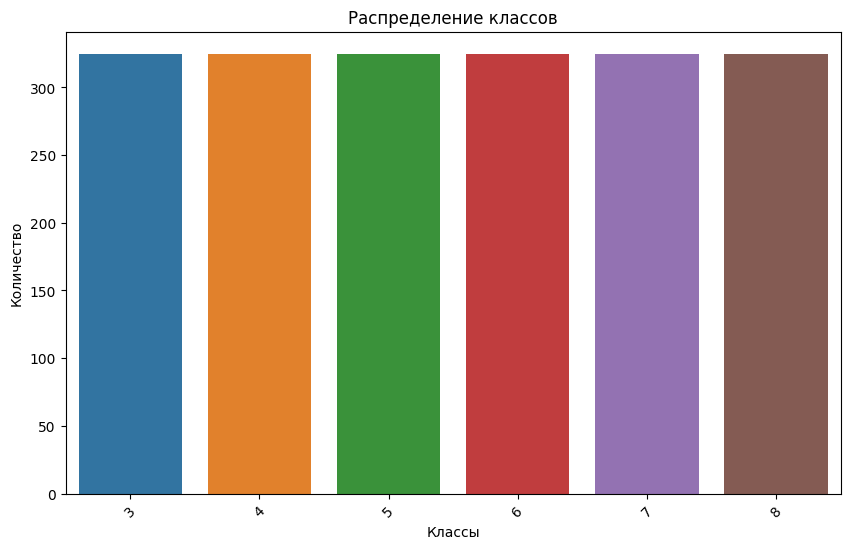

In [33]:
smote = SMOTE(random_state=42, k_neighbors=4)
X_train_wine_smote, y_train_wine_smote = smote.fit_resample(X_train_Wine, y_train_Wine)

class_counts = pd.Series(y_train_wine_smote).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Распределение классов')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Как заметно на графике, дисбаланс классов был полностью устранён, далее промасштабируем данные, это очень важно для моделей которые работают с расстоянием в данных

In [36]:
Scaler_wine = StandardScaler()
X_train_wine_smote_scale = Scaler_wine.fit_transform(X_train_wine_smote)
X_test_Wine_scale = Scaler_wine.transform(X_test_Wine)

Масштабируем данные ОБЯЗАТЕЛЬНО после train_test_split чтобы не было утечки данных в тестовую выборку и модель показывала корректные метрики

### Препроцессинг данных Регрессии Результаты студентов
Проведём для начала Полиномы для признаков со степенью 2, тем самым сделаем полиномиальную регрессию, а далее промасштабируем признаки

In [40]:
poly_student = PolynomialFeatures(degree=2)
X_train_Student_poly = poly_student.fit_transform(X_train_Student)
X_test_Student_poly = poly_student.transform(X_test_Student)

Scaler_student = StandardScaler()
X_train_Student_poly_scale = Scaler_student.fit_transform(X_train_Student_poly)
X_test_Student_poly_scale = Scaler_student.transform(X_test_Student_poly)

### Создание моделей, обучение на обработанных данных и применение GridSearchCV для подбора гиперпараметров

In [117]:
log_params_wine = {
    'C': [0.1, 1, 2, 5, 10],
    'penalty': ['l1', 'l2']
}

Logistic_wine = LogisticRegression(multi_class='multinomial', solver='lbfgs')
Logistic_wine_grid = GridSearchCV(estimator=Logistic_wine, param_grid=log_params_wine, cv=5)
Logistic_wine_grid.fit(X_train_wine_smote_scale, y_train_wine_smote)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.1, 1, 2, 5, 10], 'penalty': ['l1', 'l2']})

In [118]:
linear_params_student = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

ridge_student = Ridge()
ridge_student_grid = GridSearchCV(estimator=ridge_student, param_grid=linear_params_student, cv=5)
ridge_student_grid.fit(X_train_Student_poly_scale, y_train_Student)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

После успешного обучения моделей, выведем метрики нового бейзлайна и сравним результаты

In [121]:
Wine_predict = Logistic_wine_grid.predict(X_test_Wine_scale)
Student_predict = ridge_student_grid.predict(X_test_Student_poly_scale)

print('Метрики Классификации качества Вина на новом бейзлайне:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов на новом бейзлайне:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина на новом бейзлайне:
Accuracy:  0.4417989417989418 
Recall:    0.4417989417989418 
Precision: 0.6059856339312018 
F1:        0.4963102743650812
Метрики Регрессии по экзаменам студентов на новом бейзлайне:
MAE:  3.2340295404417048 
RMSE: 4.189521895152169 
MAPE: 0.03844424769829235


### Метрики Классификации качества Вина на новом бейзлайне
Метрики классификации повели себя только хуже на новом бейзлайне, что говорит, что масштабированние признаков для Логистической регрессии только навредило ей в работоспособности.

### Метрики Регрессии по экзаменам студентов на новом бейзлайне
При проведении Масштабирование, добавление Полиномов и применение Регуляризации Ridge модель толком никак не изменилась, но стала тяжелее. Так же в связи с тем, что при применении Rigde регуляризации метрики не стали хуже, можно уверенно сказать, что в базовом бейзлайне Переобучения модели не было.

# 4.Имплементация алгоритма машинного обучения 

### a. Самостоятельно имплементировать алгоритмы машинного обучения (для классификации и регрессии)
- Модель Логистической регрессии для классификации - Задача классификации качества вина

In [47]:
class OurLinearRegression:
    def __init__(self, fit_intercept=True):
        self.weights = None
        self.fit_intercept = fit_intercept

    def _to_numpy(self, X):
        # Оставляем только числовые признаки
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.select_dtypes(include=[np.number])
        return np.asarray(X, dtype=float)

    def _add_bias(self, X):
        # Добавляем столбец единиц: [1, x1, x2, ...]
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = self._to_numpy(X)
        y = np.asarray(y, dtype=float)

        if self.fit_intercept:
            X = self._add_bias(X)

        # Решаем нормальным уравнением — w = (X^T X)^(-1) X^T y
        XtX = X.T @ X

        # Если XtX необратима — используем псевдообратную
        try:
            X_inv = np.linalg.inv(XtX)
        except np.linalg.LinAlgError:
            X_inv = np.linalg.pinv(XtX)

        self.weights = X_inv @ X.T @ y
        return self

    def predict(self, X):
        X = self._to_numpy(X)
        if self.fit_intercept:
            X = self._add_bias(X)
        return X @ self.weights

    def get_params(self, deep=True):
        return {"fit_intercept": self.fit_intercept}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

- Модель Линейной регрессии для Регрессии - Задача регрессионной оценки по результатам студентов

In [94]:
class OurLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        self.classes_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # Преобразуем y в индексы от 0 до n_classes-1
        y_encoded = np.array([np.where(self.classes_ == y_i)[0][0] for y_i in y])
        y_encoded = np.eye(n_classes)[y_encoded]

        # Инициализация весов и смещений для каждого класса
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        for _ in range(self.n_iter):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._softmax(linear_model)

            # Вычисляем градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y_encoded))
            db = (1 / n_samples) * np.sum(y_predicted - y_encoded, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._softmax(linear_model)
        class_indices = np.argmax(y_predicted, axis=1)
        return self.classes_[class_indices]

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### b. Обучить имплементированные модели (для классификации и регрессии) для выбранных наборов данных

In [96]:
Logistic_Wine = OurLogisticRegression()
Linear_Student = OurLinearRegression()

Logistic_Wine.fit(X_train_Wine, y_train_Wine)
Linear_Student.fit(X_train_Student, y_train_Student)

### c. Оценить качество имплементированных моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных
### d. Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2 

In [98]:
Wine_predict = Logistic_Wine.predict(X_test_Wine)
Student_predict = Linear_Student.predict(X_test_Student)

print('Метрики Классификации качества Вина:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted", zero_division=True)} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина:
Accuracy:  0.42328042328042326 
Recall:    0.42328042328042326 
Precision: 0.6844645871455524 
F1:        0.25831150784069806
Метрики Регрессии по экзаменам студентов:
MAE:  3.207746556819391 
RMSE: 4.198223989077945 
MAPE: 0.03818857511502572


### Метрики Имплементированной модели - Классификации качества Вина на первом бейзлайне
Метрики Имплементированной модели на базовой модели показали себя так же довольно посредственно, а так же заметная большая разница Accuracy и F1, что нам говорит о том, что модель очень сильно спотыкается из-за дисбаланса классов.

### Метрики Метрики Имплементированной модели - Регрессии по экзаменам студентов на первом бейзлайне
Метрики Имплементированной модели на первом бейзлайне показали себя очень хорошо, чтобы убедиться, что это не переобучение, а правда хорошие метрики, на следующем бейзлайне применим Ridge регуляризацию для модели. 

### f. Добавить техники из улучшенного бейзлайна (пункт 3с)
- Функция для подбора гиперпараметров к модели и использование Кросс-валидации

In [106]:
from itertools import product
from sklearn.model_selection import StratifiedKFold

def Our_GridSearchCV(model_class, param_grid, X, y, cv=5, random_state=42):
    X = np.asarray(X)
    y = np.asarray(y)
    
    # Создаем стратифицированные фолды
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    best_score = -np.inf
    best_params = None
    
    # Генерируем все комбинации параметров
    keys = list(param_grid.keys())
    combinations = list(product(*param_grid.values()))
    
    for combo in combinations:
        params = dict(zip(keys, combo))
        scores = []
        
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Создаем и обучаем модель
            model = model_class(**params)
            model.fit(X_train, y_train)
            
            # Предсказываем и вычисляем accuracy
            y_pred = model.predict(X_val)
            accuracy = np.mean(y_pred == y_val)
            scores.append(accuracy)
        
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    
    return best_params

- Модель Линейной регрессии в Ridge регуляризацией 

In [108]:
class OurRidgeRegression:
    def __init__(self, alpha=1.0, fit_intercept=True):
        self.alpha = alpha
        self.weights = None
        self.fit_intercept = fit_intercept

    def _to_numpy(self, X):
        # Оставляем только числовые признаки
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.select_dtypes(include=[np.number])
        return np.asarray(X, dtype=float)

    def _add_bias(self, X):
        # Добавляем столбец единиц: [1, x1, x2, ...]
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y):
        X = self._to_numpy(X)
        y = np.asarray(y, dtype=float)

        if self.fit_intercept:
            X = self._add_bias(X)

        n_features = X.shape[1]
        
        # Ridge регрессия: w = (X^T X + alpha * I)^(-1) X^T y
        XtX = X.T @ X
        
        # Добавляем регуляризацию (L2 penalty)
        # Для intercept не добавляем регуляризацию, если он есть
        if self.fit_intercept:
            # Создаем матрицу регуляризации с нулем для intercept
            regularization_matrix = self.alpha * np.eye(n_features)
            regularization_matrix[0, 0] = 0  # Не регуляризуем intercept
        else:
            regularization_matrix = self.alpha * np.eye(n_features)
        
        # Решаем (X^T X + alpha * I) w = X^T y
        try:
            X_inv = np.linalg.inv(XtX + regularization_matrix)
        except np.linalg.LinAlgError:
            X_inv = np.linalg.pinv(XtX + regularization_matrix)

        self.weights = X_inv @ X.T @ y
        return self

    def predict(self, X):
        X = self._to_numpy(X)
        if self.fit_intercept:
            X = self._add_bias(X)
        return X @ self.weights

    def get_params(self, deep=True):
        return {"alpha": self.alpha, "fit_intercept": self.fit_intercept}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

### g. Обучить модели (для классификации и регрессии) для выбранных наборов данных
- Поиск гиперпараметров для Классификации

In [133]:
parameters_LogReg = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_iter': [500, 1000, 2000]
}

best_params_wine = Our_GridSearchCV(OurLogisticRegression, parameters_LogReg,  X_train_wine_smote_scale, y_train_wine_smote,cv=5)
best_logreg_wine = OurLogisticRegression(**best_params_wine)
best_logreg_wine.fit(X_train_wine_smote_scale, y_train_wine_smote)

- Обучение моделей

In [115]:
Ridge_Student = OurRidgeRegression()
Ridge_Student.fit(X_train_Student_poly_scale, y_train_Student)

### h. Оценить качество моделей (для классификации и регрессии) по выбранным метрикам на выбранных наборах данных

In [134]:
Wine_predict = best_logreg_wine.predict(X_test_Wine_scale)
Student_predict = Ridge_Student.predict(X_test_Student_poly_scale)

print('Метрики Классификации качества Вина на новом бейзлайне:')
print(f'Accuracy:  {accuracy_score(y_test_Wine, Wine_predict)} \n'
      f'Recall:    {recall_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'Precision: {precision_score(y_test_Wine, Wine_predict, average="weighted")} \n'
      f'F1:        {f1_score(y_test_Wine, Wine_predict, average="weighted")}')
print('=====================================')
print('Метрики Регрессии по экзаменам студентов на новом бейзлайне:')
print(f'MAE:  {mean_absolute_error(y_test_Student, Student_predict)} \n'
      f'RMSE: {np.sqrt(mean_squared_error(y_test_Student, Student_predict))} \n'
      f'MAPE: {mean_absolute_percentage_error(y_test_Student, Student_predict)}')

Метрики Классификации качества Вина на новом бейзлайне:
Accuracy:  0.4365079365079365 
Recall:    0.4365079365079365 
Precision: 0.5978670553888259 
F1:        0.490063004823415
Метрики Регрессии по экзаменам студентов на новом бейзлайне:
MAE:  3.2340295404383443 
RMSE: 4.189521895156384 
MAPE: 0.03844424769824977


### Метрики Имплементированной модели - Классификации качества Вина на новом бейзлайне
Метрики Имплементированной модели на новом бейзлайне - Модель показала себя неплохо на данной задаче, так же прекрасно видно как Дисбаланс классов смог устранить проблемы. Accuracy можно сказать сравнялся с F1, но модель показала себя немного хуже чем модель из sklearn на новом бейзлайне.

### Метрики Метрики Имплементированной модели - Регрессии по экзаменам студентов на первом бейзлайне
Метрики Имплементированной модели на новом бейзлайне - Модель на задач регрессии показала себя превосходно, метрики с прошлого бейзлайна толком не изменились, что говорит нам о том, что переобучения тут не было.

# Вывод по проделанной работе

В ходе лабораторной работы мы работали с двумя датасетами - Данные на задачу много классовой классификации, оценить качество вина, вторая задача Регрессионного характера, предсказать результаты студентов исходя из их привычек и поведения студентов. Работали мы сразу с двумя линейными моделями: Логистическая регрессия для Классификации и Линейная регрессия для задачи регрессии. Линейная регрессия показала себя с самого начала очень хорошо на наших данных, что говорит линейности в данных, так же при помощи Ridge регуляризации можно сказать, что переобучения не обнаружено. Логистическая регрессия показала себя тоже неплохо. Метрика Accuracy 0.4-0.5 это довольно маленькое значение, но данных у нас мало, а классов 10, исходя из этого модель справилась неплохо, так же заметно как smote, устраннение дисбаланса сильно помогло нам при обучении модели.